## Lab 6 code

### Segmentation of satellite data

#### Load in the image and do basic transformations if needed

In [62]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from matlab_functions import *
from skimage import io, color
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(256, 256)
0.8
(818, 934, 3)
(764012, 3)
1.0
0.00392156862745098


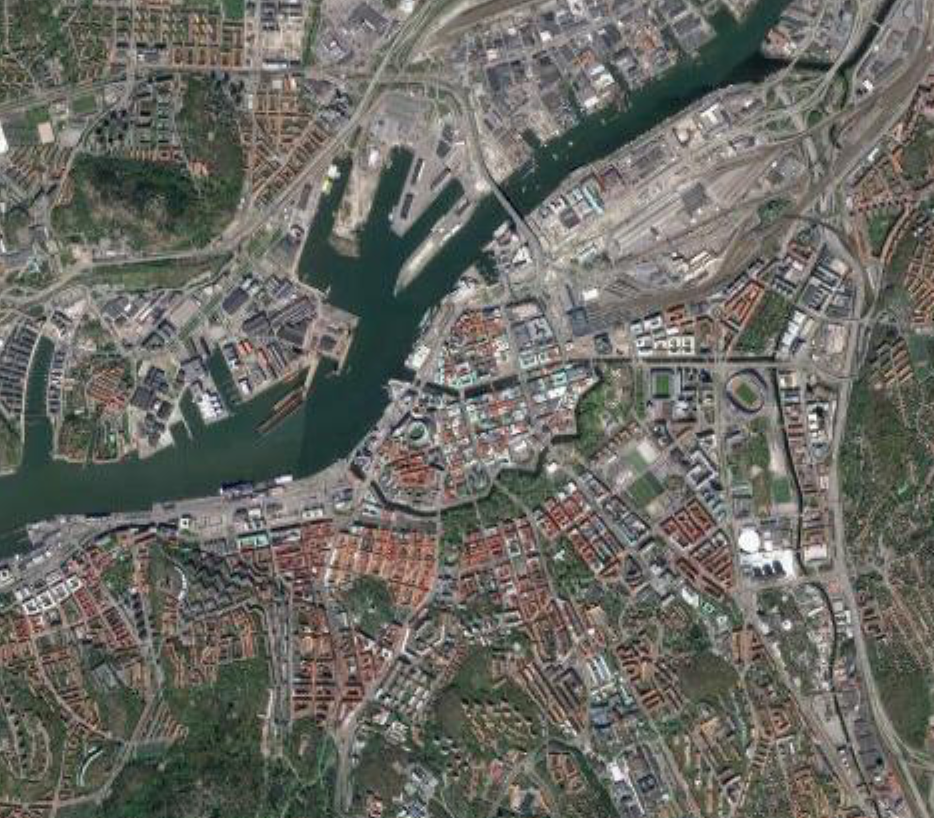

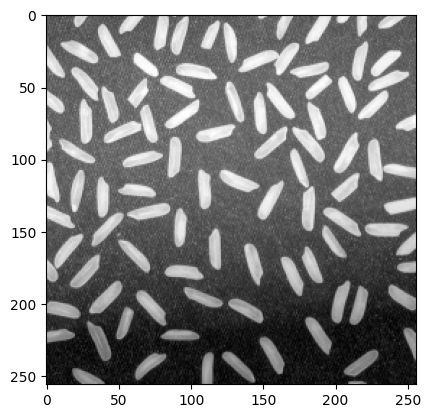

In [70]:
image = Image.open("gothenburg_satellite.png")
rice = Image.open("rice.png")
rice = cv2.imread("rice.png", 0)
data = np.array(image).astype(np.double)[:, :, :-1] / 255
rice_data = np.array(rice).astype(np.double)[26:282, 83:339] / 255
print(rice_data.shape)
print(rice_data.max())
data_flattened = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
rice_data_flat = rice_data.reshape(rice_data.shape[0]*rice_data.shape[1])
print(data.shape)
print(data_flattened.shape)
print(data.max())
print(data.min())
image.show()
plt.imshow(rice_data, cmap='gray')
a = rice_data[150, :]
b = rice_data[:, 150]

### Converting image to relative colors and LAB colorspace

In [22]:
data_flattened_rel = data_flattened / data_flattened.sum(axis=1)[:, np.newaxis]
data_flattened_lab_full = color.rgb2lab(data_flattened*255)
data_flattened_lab = color.rgb2lab(data_flattened)
print(data_flattened_lab.max())

100.0


#### Plot helper function

In [3]:
def plotKclasses(cl, K, stacked_image):
    for i in range(K):
        I_class = stacked_image.copy()
        I_class[cl != i, :] = 1
        plt.imshow(I_class.reshape(818, 934, 3))
        plt.show()

#### Perform segmentation using kmeans

In [31]:
k = 3
idx, pars = normmix_kmeans(x=data_flattened_rel, K=k)
from sklearn.cluster import KMeans
test = KMeans(n_clusters=k, n_init=50).fit_predict(data_flattened_lab_full)

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [32]:
plotKclasses(test, k, data_flattened)

#### Using normmix_sgd

In [45]:
k = 3
idx, pars = normmix_kmeans(x=data_flattened, K=k)
cl, p = normmix_classify(x=data_flattened, pars=pars)
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
test = GaussianMixture(n_components=k).fit_predict(StandardScaler().fit_transform(data_flattened_lab_full))#data_flattened_lab_full / data_flattened_lab_full.max(axis=0))

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


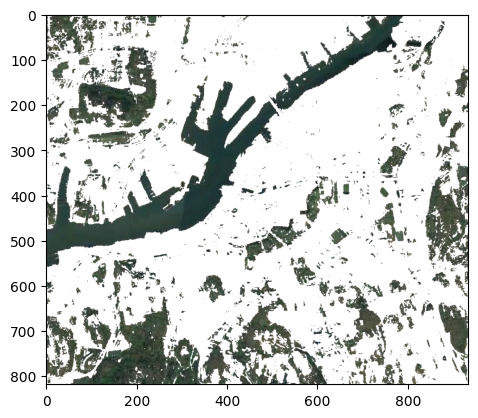

In [46]:
plotKclasses(test, k, data_flattened)

## Rice

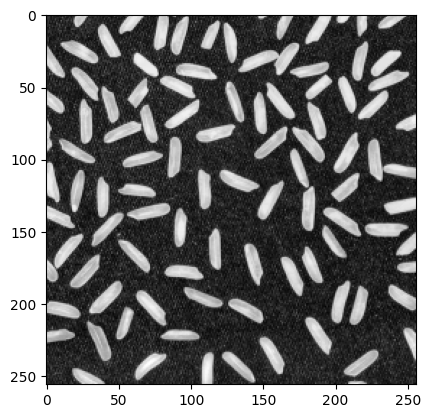

In [125]:

struct_elem_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30, 30))
struct_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
dilate = cv2.dilate(rice_data, struct_elem, iterations=1)
erosion = cv2.erode(rice_data, struct_elem, iterations=1)
opening = cv2.morphologyEx(rice_data, cv2.MORPH_OPEN, struct_elem_open, iterations=1)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 20))
ax1.imshow(dilate, cmap="gray")
ax1.set_title("Dilated")
ax2.imshow(erosion, cmap="gray")
ax2.set_title("Erosion")
ax3.imshow(opening, cmap="gray")
ax3.set_title("Opening")
ax4.imshow(rice_data, cmap="gray")
ax4.set_title("Original")
plt.show()
rice_back_rem = rice_data - opening
rice_back_rem_er = cv2.dilate(cv2.erode(rice_back_rem, struct_elem, iterations=3), struct_elem, iterations=2)
plt.imshow(rice_back_rem, cmap="gray")
plt.show()
plt.imshow(rice_back_rem_er, cmap="gray")
plt.show()

### GMM segmentation

(65536,)


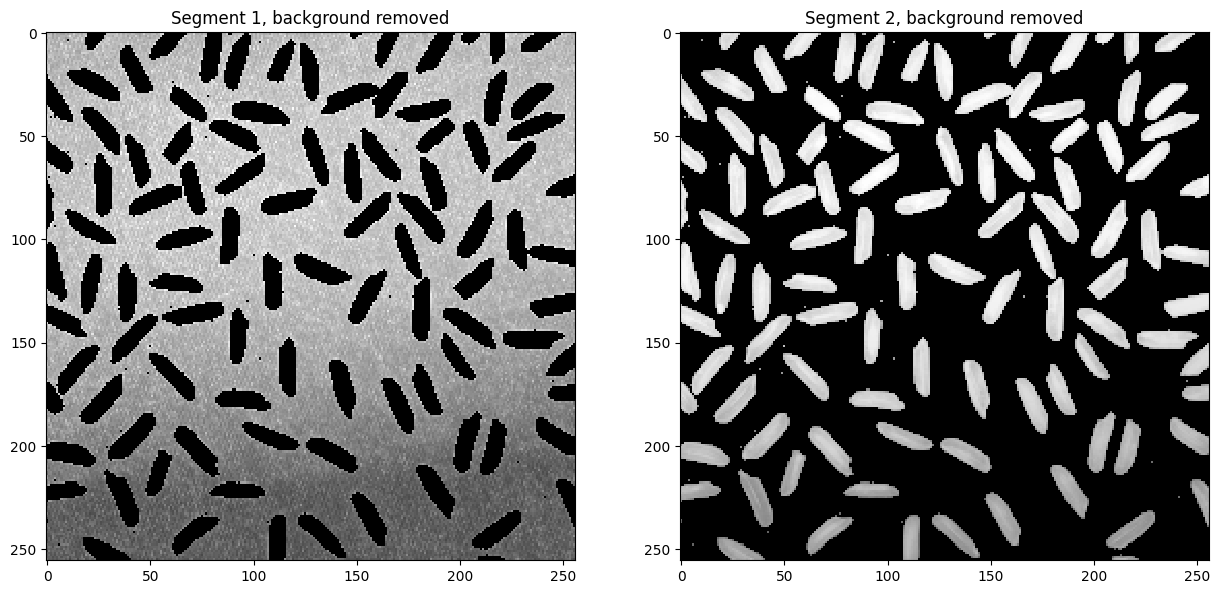

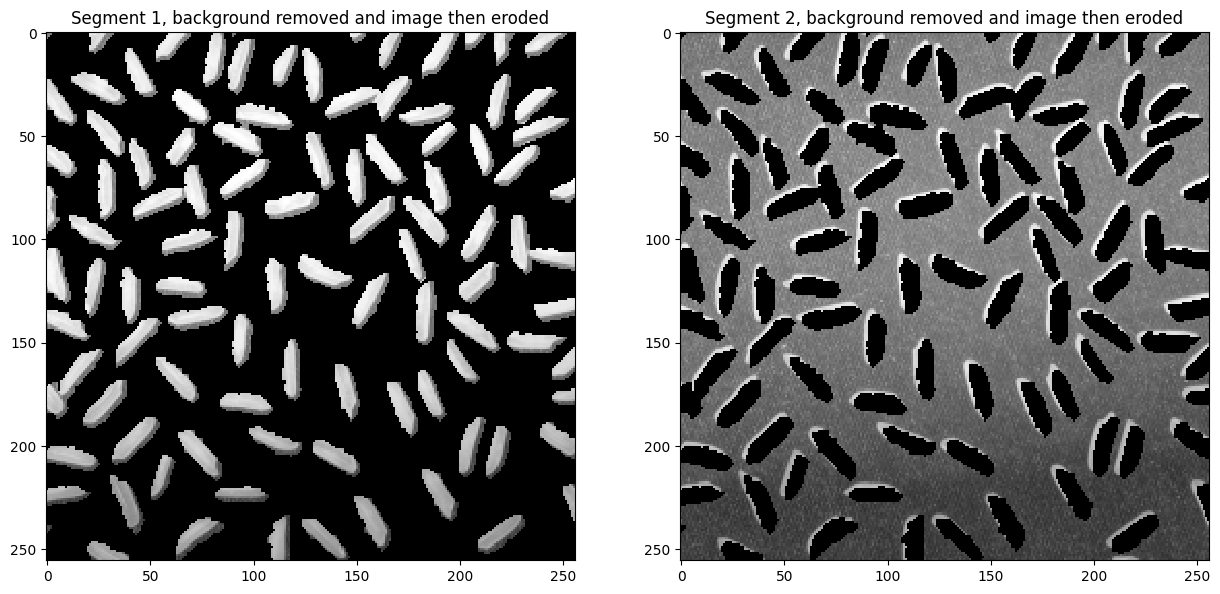

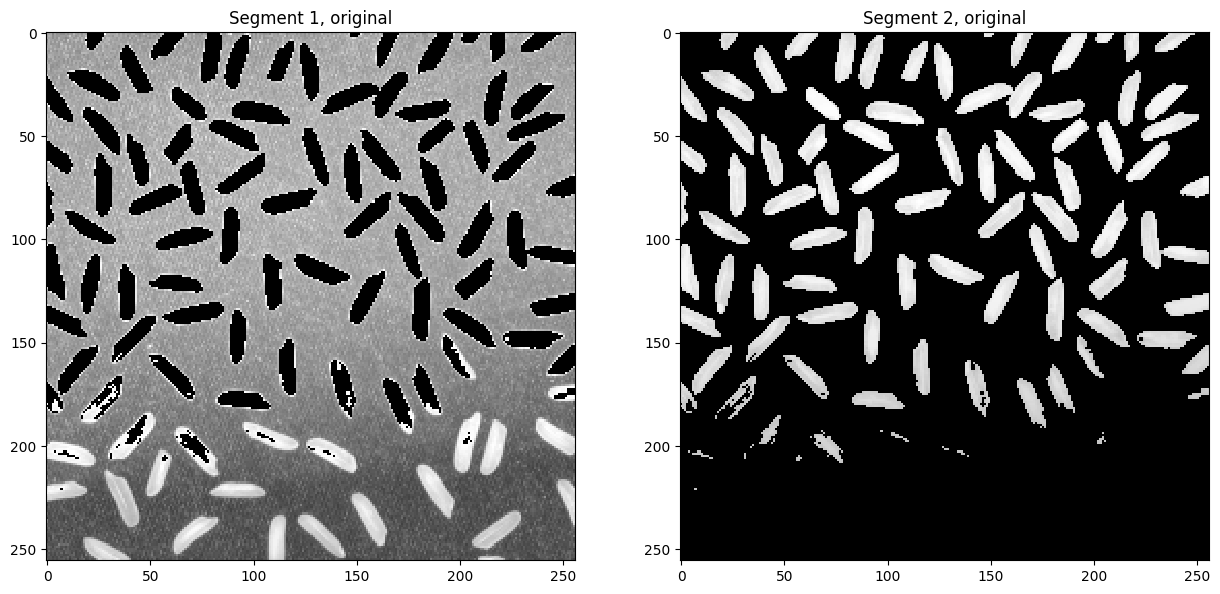

In [126]:
k = 2
rice_back_rem_flat = rice_back_rem.reshape(rice_back_rem.shape[0]*rice_back_rem.shape[1])
rice_back_rem_er_flat = rice_back_rem_er.reshape(rice_back_rem_er.shape[0]*rice_back_rem_er.shape[1])
print(rice_back_rem_flat.shape)
res1 = GaussianMixture(n_components=k).fit_predict(rice_back_rem_flat[:, np.newaxis])

seg1 = rice_data_flat.copy()
seg1[res1 == 1] = 0

seg2 = rice_data_flat.copy()
seg2[res1 == 0] = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(seg1.reshape(256, 256), cmap="gray", interpolation="none")
ax1.set_title("Segment 1, background removed")
ax2.imshow(seg2.reshape(256, 256), cmap="gray", interpolation="none")
ax2.set_title("Segment 2, background removed")
plt.show()

res3 = GaussianMixture(n_components=k).fit_predict(rice_back_rem_er_flat[:, np.newaxis])

seg1 = rice_data_flat.copy()
seg1[res3 == 1] = 0

seg2 = rice_data_flat.copy()
seg2[res3 == 0] = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(seg1.reshape(256, 256), cmap="gray", interpolation="none")
ax1.set_title("Segment 1, background removed and image then eroded")
ax2.imshow(seg2.reshape(256, 256), cmap="gray", interpolation="none")
ax2.set_title("Segment 2, background removed and image then eroded")
plt.show()

res2 = GaussianMixture(n_components=k).fit_predict(rice_data_flat[:, np.newaxis])
seg1 = rice_data_flat.copy()
seg1[res2 == 1] = 0

seg2 = rice_data_flat.copy()
seg2[res2 == 0] = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(seg1.reshape(256, 256), cmap="gray", interpolation="none")
ax1.set_title("Segment 1, original")
ax2.imshow(seg2.reshape(256, 256), cmap="gray", interpolation="none")
ax2.set_title("Segment 2, original")
plt.show()

